In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import CoherenceModel
import tmtoolkit
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
# preprocess text
# keep asterisks as they may be used to censor vulgar words

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re

# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [7]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_pickle('../Pre-Processed Files/toxic_only_train_shortlisted_preprocessed.pkl')
toxic_only_train_shortlisted

,comment_text,target,preprocessed_text
4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
5,ur a sh*tty comment.,None,ur sh * tty comment
13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...
1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


# Classification Models (Task 1)

In [8]:
from sklearn.model_selection import train_test_split

X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [10]:
# for evaluation of performance

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, cohen_kappa_score, log_loss

In [11]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=["Disability", "Gender", "None", "Race", "Religion"])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

## Logistic Regression

In [13]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

In [14]:
pd.Series(y_pred).value_counts()

None          35035
Gender         3427
Race           2670
Religion       1909
Disability      260
dtype: int64

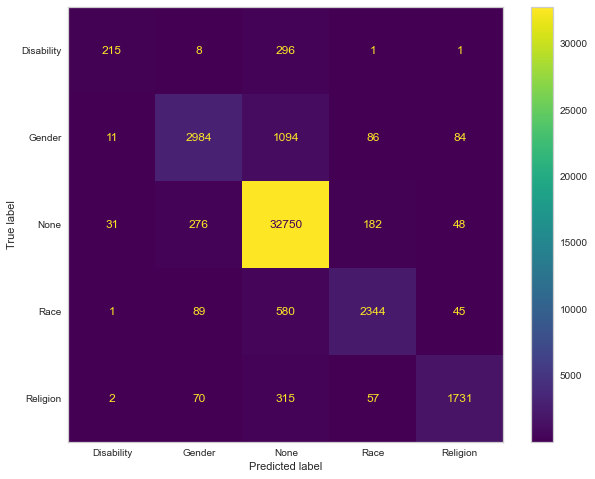

In [15]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Disability", "Gender", "None", "Race", "Religion"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.77      0.82      3059
    Religion       0.91      0.80      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.88      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



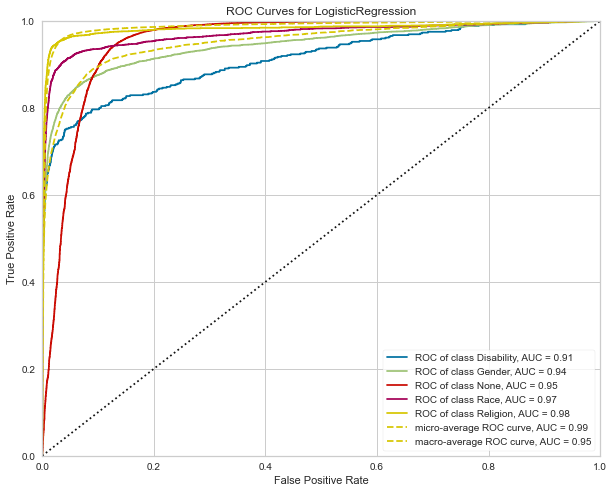

In [17]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

In [18]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred)

0.7967945297948523

In [19]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred)

0.7918526215740387

In [20]:
# log loss

y_preb_probs = logreg.predict_proba(tfidf_test)
log_loss(y_test, y_preb_probs)

0.2584012865834067

## Multinomial NB

In [23]:
MLNB = MultinomialNB()
MLNB.fit(tfidf_train, y_train)
y_pred = MLNB.predict(tfidf_test)

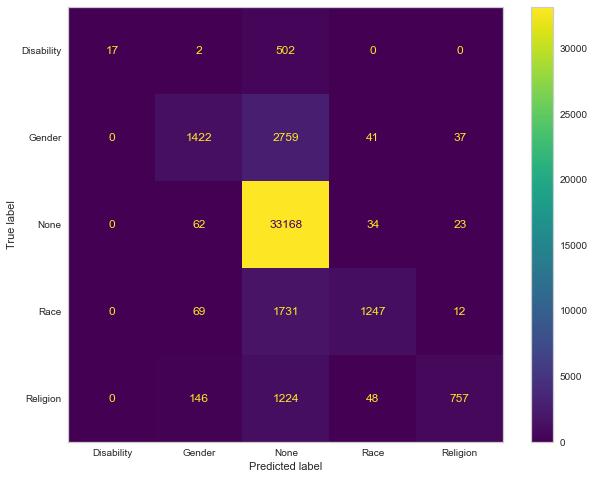

In [24]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Disability", "Gender", "None", "Race", "Religion"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       1.00      0.03      0.06       521
      Gender       0.84      0.33      0.48      4259
        None       0.84      1.00      0.91     33287
        Race       0.91      0.41      0.56      3059
    Religion       0.91      0.35      0.50      2175

    accuracy                           0.85     43301
   macro avg       0.90      0.42      0.50     43301
weighted avg       0.85      0.85      0.81     43301



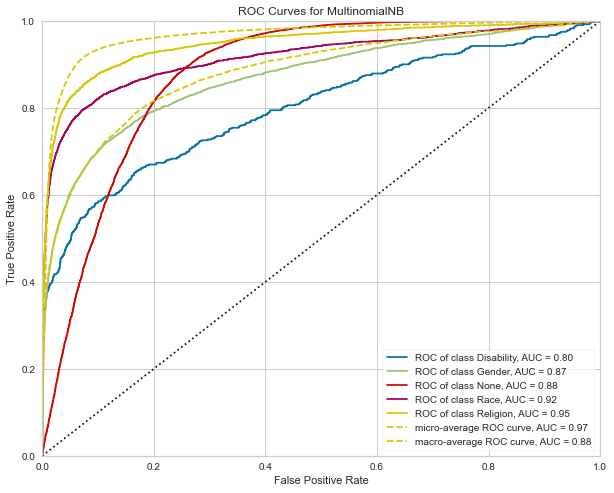

In [26]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(MLNB, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

In [27]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred)

0.5398532500881542

In [28]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred)

0.47402351661596054

In [29]:
# log loss

y_preb_probs = MLNB.predict_proba(tfidf_test)
log_loss(y_test, y_preb_probs)

0.48883768046282644

In [31]:
train_sentence = []
test_sentence = []
for row in X_train.to_numpy():
    train_sentence.append(row)
for row in X_test.to_numpy():
    test_sentence.append(row)

In [32]:
max_words = 30000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentence)
sequences = tok.texts_to_sequences(train_sentence)
X_train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_train_sequences_matrix

array([[    0,     0,     0, ...,    47,  1502,   700],
       [    0,     0,     0, ...,   223, 14765,  1122],
       [    0,     0,     0, ...,  1049,   183,    75],
       ...,
       [    0,     0,     0, ...,   516,  2428, 22891],
       [    0,     0,     0, ...,    84,    88,  1118],
       [    0,     0,     0, ...,   343,   127,  1174]])

In [33]:
tok.fit_on_texts(test_sentence)
sequences = tok.texts_to_sequences(test_sentence)
X_test_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_sequences_matrix

array([[   0,    0,    0, ...,  894,   82, 4260],
       [   0,    0,    0, ...,   20,  581, 2191],
       [   0,    0,    0, ..., 1229, 1443,  558],
       ...,
       [   0,    0,    0, ...,  899,   40, 3075],
       [   0,    0,    0, ..., 6010,  674, 1025],
       [   0,    0,    0, ..., 4683,  506, 2239]])

In [34]:
y_train_2 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_train_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_train_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_train_2.append([0,0,0,1,0])
    else:
        y_train_2.append([0,0,0,0,1])
y_train_2 = np.array(y_train_2)

In [36]:
y_test_2 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_test_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_test_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_test_2.append([0,0,0,1,0])
    else:
        y_test_2.append([0,0,0,0,1])
y_test_2 = np.array(y_test_2)

In [39]:
model = Sequential()
model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_sequences_matrix, y_train_2, epochs=3, batch_size=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1500000   
                                                                 
 lstm (LSTM)                 (None, 200, 100)          60400     
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 5)                 100005    
                                                                 
Total params: 1,660,405
Trainable params: 1,660,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
20207/20207 [==============================] - 247s 12ms/step - loss: 0.3139 - accuracy: 0.9125
Epoch 2/3
20207/20207 [==============================] - 280s 14ms/

In [46]:
scores = model.evaluate(X_test_sequences_matrix, y_test_2, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss:" +str (scores[0]))

Accuracy: 65.41%
Loss:1.808209776878357


In [47]:
y_pred = model.predict(X_test_sequences_matrix)

In [48]:
y_pred_2 = []

for lst in y_pred:
    max_val = 0
    for i, val in enumerate(lst):
        if val>max_val:
            max_val=val
            ind=i
    y_pred_2.append(ind)

In [49]:
y_pred_3 = []
for i in y_pred_2:
    if i==0:
        y_pred_3.append("Race")
    elif i==1:
        y_pred_3.append("Gender")
    elif i==2:
        y_pred_3.append("Religion")
    elif i==3:
        y_pred_3.append("Disability")
    else:
        y_pred_3.append("None")


In [50]:
y_pred_4 = []
for i in y_pred_2:
    if i==0:
        y_pred_4.append([1,0,0,0,0])
    elif i==1:
        y_pred_4.append([0,1,0,0,0])
    elif i==2:
        y_pred_4.append([0,0,1,0,0])
    elif i==3:
        y_pred_4.append([0,0,0,1,0])
    else:
        y_pred_4.append([0,0,0,0,1])
y_pred_4 = np.array(y_pred_4)

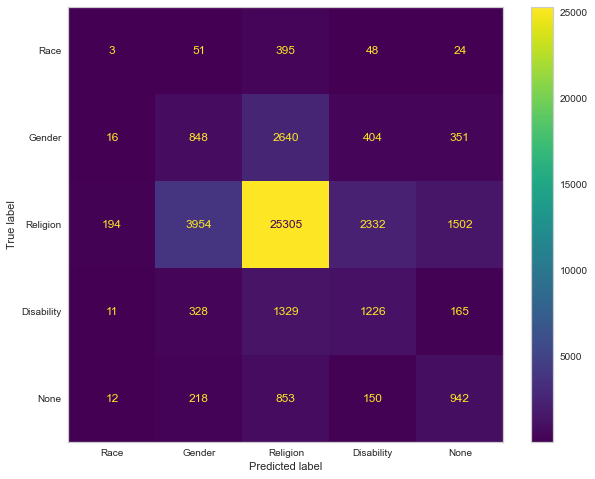

In [51]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred_3)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


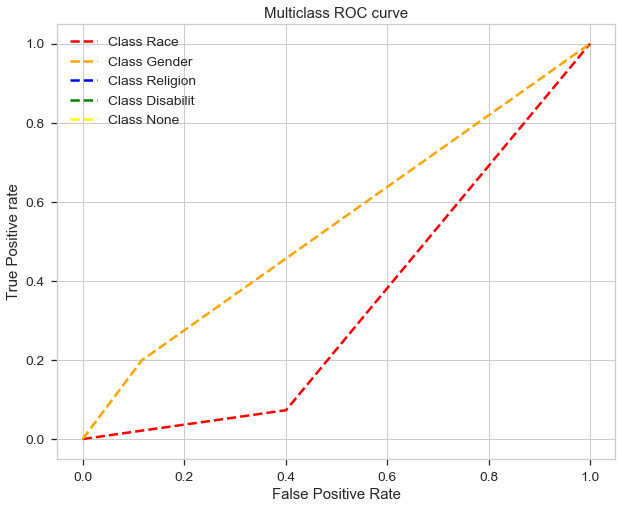

In [91]:
fpr = {}
tpr = {}
thresh ={}
n_class = ["Race", "Gender", "Religion", "Disability", "None"]
for i in range(len(n_class)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_2[:,i], y_pred_4[:,i], pos_label=i)
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Class Race ')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Class Gender')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Religion')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green', label='Class Disabilit')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class None')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [55]:
# Matthew's correlation coefficient

matthews_corrcoef(y_test, y_pred_3)

0.20820286409671196

In [56]:
# Cohen's kappa

cohen_kappa_score(y_test, y_pred_3)

0.20588643456987532

# LDA (Task 2)

In [83]:
toxic_only_train_shortlisted = pd.read_pickle('../Pre-Processed Files/toxic_only_train_shortlisted_preprocessed.pkl')

In [84]:
stop_words = stopwords.words('english')
stop_words.extend(['com', 'http', 'wwww', 'like', 'say', 'need', 'good', 'want', 'people', 'know', 'right', 'make', 'thing'])
lemmatizer = WordNetLemmatizer()
# print(stop_words)

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [85]:
toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['trump', 'stupid', 'time', 'think', 'white', 'year', 'country', 'way', 'woman', 'idiot', 'president', 'really', 'black', 'american', 'liberal', 'state', 'going', 'racist', 'man', 'comment']


C:\Users\wei-d\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


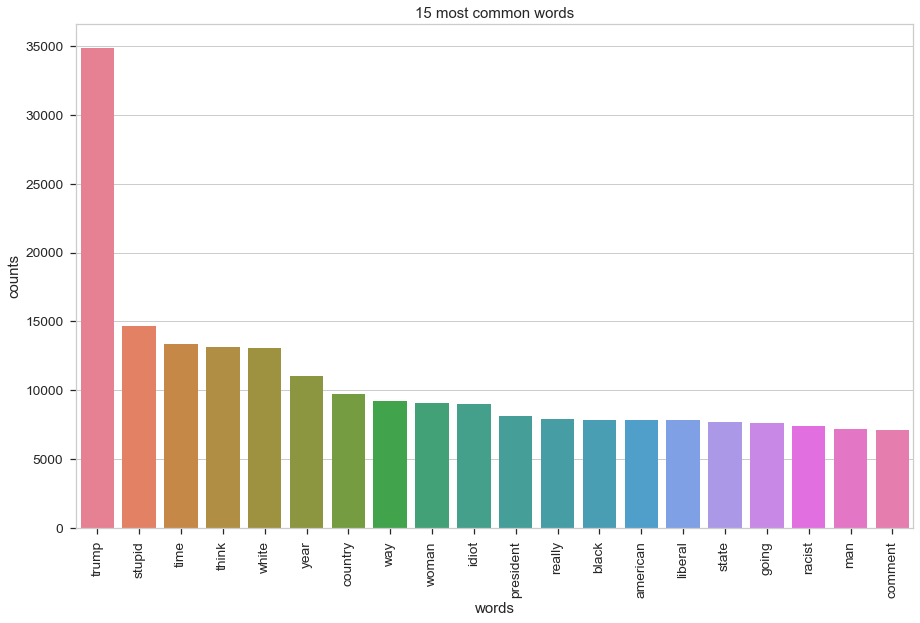

In [86]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
#     plt.show()
    print(words)

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(toxic_only_train_shortlisted['preprocessed_text'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Sklearn LDA

In [87]:
lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text']
tokenized_docs = [word_tokenize(doc) for doc in lda_preprocessed_comments]

In [88]:
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(list(lda_preprocessed_comments))

In [89]:
vocab_list = np.array([x for x in count_vectoriser.vocabulary_.keys()])


In [90]:

sklearn_model_list = []
sklearn_perplexity_values = []
sklearn_model_topics = []
sklearn_coherence_values= []

for num_topics in range(2, 20, 2):
    sklearn_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    output_x = sklearn_lda_x.fit_transform(lda_count_vecs)
    sklearn_model_topics.append(num_topics)
    sklearn_model_list.append(sklearn_lda_x)
    perplexity_x = sklearn_lda_x.perplexity(lda_count_vecs)
    sklearn_perplexity_values.append(perplexity_x)
    coherence_x = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=sklearn_lda_x.components_, 
                        dtm=output_x,
                        vocab=vocab_list, 
                        texts=tokenized_docs,
                        return_mean = True)
    sklearn_coherence_values.append(coherence_x)
    print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x) + ", Coherence Score: " + str(coherence_x))


TypeError: unsupported operand type(s) for +: 'lil_matrix' and 'lil_matrix'

### sklearn 5 topics

In [75]:
num_topics = 5
sklearn_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
output_x = sklearn_lda_x.fit_transform(lda_count_vecs)
perplexity_x = sklearn_lda_x.perplexity(lda_count_vecs)
coherence_x = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x.components_, 
                    dtm=output_x,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
# sklearn_coherence_values.append(coherence_x)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x) + ", Coherence Score: " + str(coherence_x))

TypeError: unsupported operand type(s) for +: 'lil_matrix' and 'lil_matrix'

### sklearn 7 topics

In [ ]:
num_topics = 7
sklearn_lda_x2 = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
output_x2 = sklearn_lda_x2.fit_transform(lda_count_vecs)
perplexity_x2 = sklearn_lda_x2.perplexity(lda_count_vecs)
coherence_x2 = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x2.components_, 
                    dtm=output_x2,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x2) + ", Coherence Score: " + str(coherence_x2))

In [ ]:
import matplotlib.pyplot as plt

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, sklearn_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.grid()
plt.show()
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, sklearn_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
# Generate the visuals
visual = pyLDAvis.sklearn.prepare(selected_lda_model, lda_count_vecs, count_vectoriser, mds='tsne')
visual

### Gensim LDA

In [76]:
def lda_preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

In [77]:
gensim_lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text'].map(lda_preprocess)
dictionary = corpora.Dictionary(gensim_lda_preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)
bow_corpus = [dictionary.doc2bow(doc) for doc in gensim_lda_preprocessed_comments]

In [78]:
# find optimal k (no. of topics) and plot graph visually

model_list = []
perplexity_values = []
coherence_values = []
model_topics = []

for i in range(2, 20, 2):
    print("--------Topics: " + str(i) +'----------')
    lda_model = models.LdaMulticore(bow_corpus, num_topics=i,id2word=dictionary, passes=2, workers=2)
#     lda_model.fit_transform(bow_corpus)
    model_topics.append(i)
    model_list.append(lda_model)
    perplexity_cal = np.exp(-1. * lda_model.log_perplexity(bow_corpus))
    perplexity_values.append(perplexity_cal)
    print("#Topics: " + str(i) + ", Perplexity Score: " + str(perplexity_cal))
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=gensim_lda_preprocessed_comments,dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print("#Topics: " + str(i) + ', Coherence Score: ', coherence_lda)


--------Topics: 2----------
#Topics: 2, Perplexity Score: 3906.5662892996893


TypeError: unsupported operand type(s) for +: 'lil_matrix' and 'lil_matrix'

In [ ]:

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.grid()
plt.show()
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
# Generate the visuals
visual = pyLDAvis.gensim_models.prepare(model_list[2], bow_corpus, dictionary = model_list[2].id2word, mds='tsne')
visual

### Final sklearn LDA - 6 topics

In [ ]:
num_topics = 6
sklearn_lda_x3 = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1, random_state = 42)
output_x3 = sklearn_lda_x3.fit_transform(lda_count_vecs)
# sklearn_model_topics.append(num_topics)
# sklearn_model_list.append(sklearn_lda_x3)
perplexity_x3 = sklearn_lda_x3.perplexity(lda_count_vecs)
# sklearn_perplexity_values.append(perplexity_x3)
coherence_x3 = tmtoolkit.topicmod.evaluate.metric_coherence_gensim(measure='c_v', 
                    top_n=25, 
                    topic_word_distrib=sklearn_lda_x3.components_, 
                    dtm=output_x3,
                    vocab=vocab_list, 
                    texts=tokenized_docs,
                    return_mean = True)
# sklearn_coherence_values.append(coherence_x3)
print("#Topics: " + str(num_topics) + ", Perplexity Score: " + str(perplexity_x3) + ", Coherence Score: " + str(coherence_x3))

In [ ]:
selected_lda_model = sklearn_lda_x3
for x, topic in enumerate(selected_lda_model.components_):
    print("topic", x)
    print(topic)

In [ ]:
lda_output = selected_lda_model.transform(lda_count_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(sklearn_lda_x3.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lda_preprocessed_comments))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
num_doc_to_show = 10  # change this to display the number of documents shown below
df_document_topics = df_document_topic.head(num_doc_to_show).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vectoriser, lda_model=selected_lda_model, n_words=10):
    keywords = np.array(count_vectoriser.get_feature_names())
    topic_keywords = []
    for topic_weights in selected_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectoriser, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

In [ ]:
feature_names = count_vectoriser.get_feature_names()

In [ ]:
# write a function to display the 10 topics and for each topic we choose the top most frequent words. 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(selected_lda_model, feature_names, 15)

### Sub-topic distribution across documents


In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']

### Topic analysis 


In [ ]:
df_document_topic_view = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)
df_document_topic_view['dominant_topic'] = dominant_topic

#### Topic 0

In [ ]:
df_document_topic_view.sort_values("Topic0", ascending = False).head(10)

#### Topic 1

In [ ]:
df_document_topic_view.sort_values("Topic1", ascending = False).head(10)

#### Topic 2

In [ ]:
df_document_topic_view.sort_values("Topic2", ascending = False).head(10)

#### Topic 3

In [ ]:
df_document_topic_view.sort_values("Topic3", ascending = False).head(10)

#### Topic 4

In [ ]:
df_document_topic_view.sort_values("Topic4", ascending = False).head(10)

#### Topic 5

In [ ]:
df_document_topic_view.sort_values("Topic5", ascending = False).head(10)

### Overall analysis

In [ ]:
final_results = toxic_only_train_shortlisted.copy(deep= True)
final_results

In [ ]:
labelled_dominant_topic = []
for i in dominant_topic:
    if i == 0:
        labelled_dominant_topic.append("Generic")
    elif i == 1:
        labelled_dominant_topic.append("Canada Political")
    elif i == 2:
        labelled_dominant_topic.append("Gender Related")
    elif i == 3:
        labelled_dominant_topic.append("Racial")
    elif i == 4:
        labelled_dominant_topic.append("Religion Related")
    elif i == 5:
        labelled_dominant_topic.append("U.S. Political")

In [ ]:
final_results['dominant_topic'] = labelled_dominant_topic

In [ ]:
final_results.groupby(['target']).count()

In [ ]:
final_results.groupby(['target', 'dominant_topic']).count()